# Установка нужных библиотек

In [94]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !pip install torchdiffeq torchsde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Импорт библиотек

In [95]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde as tsde
from torchdiffeq import odeint

from typing import Tuple, Union, List
from tqdm import tqdm

torch.manual_seed(42)

# Настройка окружения

In [96]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

SEED = 42

if IN_COLAB:
    figures_dir = './'
else:
    figures_dir = '../figures/'

# Работа с данными

**Функция для 2D- и 3D-визуализации**

In [97]:
def plot_phase_trajectory(points: Union[np.ndarray, Tuple[np.ndarray]],
                          name: str = '',
                          labels: List[str] = [''],
                          mode: str = '3D',
                          use_lines: bool = False, 
                          clear: bool = True,
                          to_save: bool = False):
    assert mode in ['2D', '3D'], 'mode must be in [2D, 3D]'
    
    fig = plt.figure()
    ax = None
    
    if isinstance(points, np.ndarray):
        points = points, 
        
    assert len(labels) == len(points), f'{len(labels)} != {len(points)}'
    
    if mode == '3D':
        ax = fig.add_subplot(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        for i in range(len(points)):
            xs = points[i][:,0]
            ys = points[i][:,1]
            zs = points[i][:,2]
            
            if use_lines:
                ax.plot(xs, ys, zs, alpha=0.5)

            ax.scatter(xs, ys, zs, label=labels[i])
    else:
        ax = fig.add_subplot()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        for i in range(len(points)):
            xs = points[i][:,0]
            ys = points[i][:,1]
            
            if use_lines:
                ax.plot(xs, ys, alpha=0.5)

            ax.scatter(xs, ys, label=labels[i])
        
    # Remove ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
    if mode == '3D':
        ax.zaxis.set_ticks([])
    
    if clear:
        # First remove fill
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        # Now set color to white (or whatever is "invisible")
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        # Remove axis
        ax.set_axis_off()

        # Bonus: To get rid of the grid as well:
        ax.grid(False)
        
    ax.legend()

    if to_save:
        fig.savefig(figures_dir + name + '.png')
        
    ax.set_title(name)
    plt.show()

**Создание синтетического датасета - спирали**

In [98]:
# Parameters of lorenz system of diff. equations
LORENZ_RHO = 28
LORENZ_SIGMA = 10
LORENZ_BETA = 8/3

DATA_SIZE = 1000
INITIAL_POINT_2D = (1., -1.)
INITIAL_POINT_3D = (1., -1., 1.)
T = 25.

class Spiral(nn.Module):
    DIM = 2
    
    def __init__(self, mat: torch.Tensor):
        assert mat.shape == (self.DIM, self.DIM)
        
        super().__init__()
        self.mat = mat
        
    def forward(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        return inp**3 @ self.mat


class LorenzAttractor(nn.Module):
    DIM = 3
    
    def __init__(self,
                 rho: int = LORENZ_RHO,
                 sigma: int = LORENZ_SIGMA,
                 beta: int = LORENZ_BETA):
        super().__init__()
        
        self.rho = rho
        self.sigma = sigma
        self.beta = beta
    
    def forward(self, time: torch.Tensor, inp: torch.Tensor):
        if inp.size().numel() != self.DIM:
            raise ValueError(f'Input size != {self.DIM}')
        
        x, y, z = torch.split(inp, 1)
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z
        
        return torch.stack([dxdt, dydt, dzdt]).reshape(-1).to(inp.device)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ts = torch.linspace(0., T, DATA_SIZE).to(device)
y0 = torch.tensor(INITIAL_POINT_2D).to(device)
mat = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

with torch.no_grad():
    spiral_data = odeint(Spiral(mat), y0, ts, method='dopri5')

**Отрисовка полученных данных**

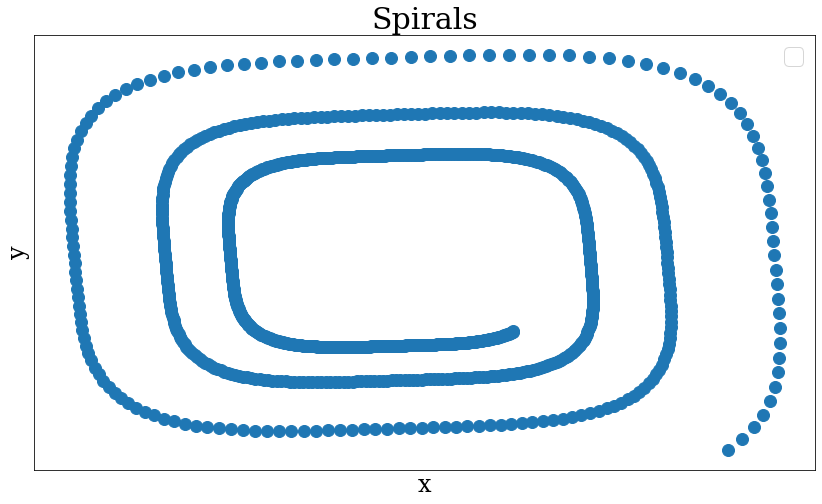

In [99]:
plot_phase_trajectory(
    spiral_data.cpu().numpy(), 
    name='Spirals',
    mode='2D',
    to_save=True,
    clear=False,
)

**Функция, генерирующая батчи для обучения модели**

In [100]:
def get_batch(data: torch.Tensor, 
              ts: torch.Tensor, 
              batch_size: int, 
              batch_time: int) -> Tuple[torch.Tensor]:
    assert data.ndim == 2 and ts.ndim == 1
    assert data.shape[0] == ts.shape[0]
    
    data_size = data.shape[0]
    start_indices = torch.from_numpy(
        np.random.choice(
            np.arange(
                data_size-batch_time,
                dtype=np.int64
            ), 
            batch_size, 
            replace=False
        )
    )
    # batch_t = (batch_time,)
    # batch_y0 = (batch_size, y0_dim)
    # batch_y = (batch_time, batch_size, y0_dim)
    batch_y0 = data[start_indices]
    batch_t = ts[:batch_time]
    batch_y = torch.stack(
        [data[start_indices + i] for i in range(batch_time)], 
        dim=0
    )
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

**Модель, параметризующая производную скрытого состояния**

In [101]:
class LorenzFunc(nn.Module):
    def __init__(self, hid_dim: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(3, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, hid_dim//2),
            nn.Tanh(),
            nn.Linear(hid_dim//2, 3)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        if inp.ndim == 1:
            inp = inp.reshape(1, -1)
        
        xy_prod = inp[:, 0] * inp[:, 1]
        xz_prod = inp[:, 0] * inp[:, 2]
        concatenated = torch.hstack(
            (inp, xy_prod.unsqueeze(1), xz_prod.unsqueeze(1))
        )
        return self.net(concatenated)
    
class SpiralFunc(nn.Module):
    def __init__(self, hid_dim: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, 2)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        return self.net(inp**3)

**Обучение модели**

In [114]:
N_ITERS = 500
TEST_FREQ = 20
BATCH_SIZE = 60
BATCH_TIME = 40
HID_DIM = 50

ode_func = SpiralFunc(HID_DIM).to(device)
optimizer = optim.Adam(
    ode_func.parameters(),
    lr=0.005,
    weight_decay=0.01
)
train_loss_arr = []
val_loss_arr = []

for itr in range(1, N_ITERS+1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(
        spiral_data,
        ts,
        BATCH_SIZE,
        BATCH_TIME
    )
    pred_y = odeint(ode_func, batch_y0, batch_t, rtol=1e-4, atol=1e-6).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    train_loss_arr.append(loss.item())

    if itr % TEST_FREQ != 0:
        continue
        
    with torch.no_grad():
        pred_y = odeint(ode_func, y0, ts, rtol=1e-4, atol=1e-6)
        loss = torch.mean(torch.abs(pred_y - spiral_data))
        val_loss_arr.append(loss.item())
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.533392
Iter 0040 | Total Loss 0.517118
Iter 0060 | Total Loss 0.333153
Iter 0080 | Total Loss 0.075761
Iter 0100 | Total Loss 0.108211
Iter 0120 | Total Loss 0.083835
Iter 0140 | Total Loss 0.205575
Iter 0160 | Total Loss 0.133089
Iter 0180 | Total Loss 0.567550
Iter 0200 | Total Loss 0.113483
Iter 0220 | Total Loss 0.118472
Iter 0240 | Total Loss 0.088746
Iter 0260 | Total Loss 0.071220
Iter 0280 | Total Loss 0.214953
Iter 0300 | Total Loss 0.322370
Iter 0320 | Total Loss 0.200176
Iter 0340 | Total Loss 0.187142
Iter 0360 | Total Loss 0.211789
Iter 0380 | Total Loss 0.031678
Iter 0400 | Total Loss 0.066937
Iter 0420 | Total Loss 0.024050
Iter 0440 | Total Loss 0.166603
Iter 0460 | Total Loss 0.099994
Iter 0480 | Total Loss 0.251723
Iter 0500 | Total Loss 0.104944


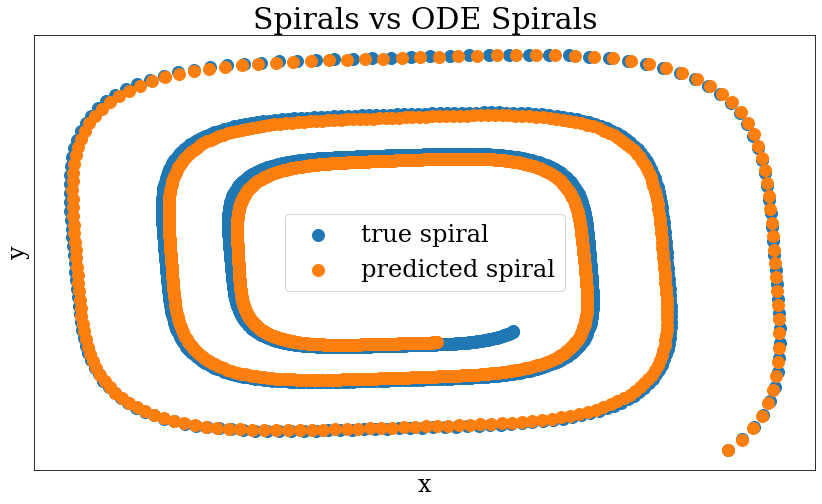

In [115]:
plot_phase_trajectory(
    (spiral_data.cpu().numpy(), pred_y.detach().cpu().numpy()), 
    name='Spirals vs ODE Spirals',
    labels=['true spiral', 'predicted spiral'],
    mode='2D',
    to_save=True,
    clear=False,
)

**Добавление шума к данным**

In [116]:
noise = torch.normal(
    torch.zeros([DATA_SIZE, 2]),
    torch.full([DATA_SIZE, 2], 0.04)
).to(device)
noisy_spirals = spiral_data + noise

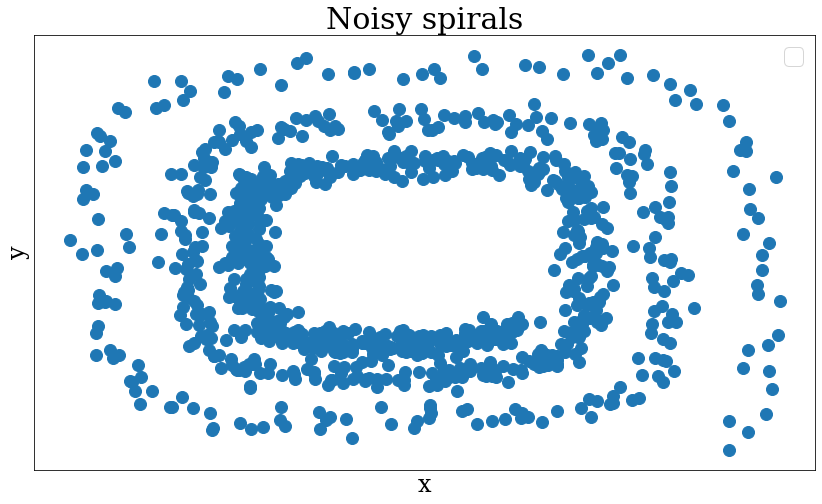

In [117]:
plot_phase_trajectory(
    noisy_spirals.cpu().numpy(), 
    name='Noisy spirals',
    mode='2D',
    to_save=True,
    clear=False,
)

**Обучение Neural ODE на зашумлённых данных**

In [118]:
noisy_func = SpiralFunc(HID_DIM).to(device)
optimizer = optim.Adam(
    noisy_func.parameters(),
    lr=0.005,
    weight_decay=0.01
)
noisy_train_loss_arr = []
noisy_val_loss_arr = []

for itr in range(1, N_ITERS+1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(
        noisy_spirals,
        ts,
        BATCH_SIZE,
        BATCH_TIME
    )
    pred_y = odeint(noisy_func, batch_y0, batch_t, rtol=1e-4, atol=1e-6).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    noisy_train_loss_arr.append(loss.item())

    if itr % TEST_FREQ != 0:
        continue
        
    with torch.no_grad():
        pred_y = odeint(noisy_func, y0, ts, rtol=1e-4, atol=1e-6)
        loss = torch.mean(torch.abs(pred_y - noisy_spirals))
        noisy_val_loss_arr.append(loss.item())
        print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.446551
Iter 0040 | Total Loss 1.864913
Iter 0060 | Total Loss 0.530247
Iter 0080 | Total Loss 0.192906
Iter 0100 | Total Loss 0.196267
Iter 0120 | Total Loss 0.358453
Iter 0140 | Total Loss 0.174803
Iter 0160 | Total Loss 0.482922
Iter 0180 | Total Loss 0.587507
Iter 0200 | Total Loss 0.125453
Iter 0220 | Total Loss 0.559558
Iter 0240 | Total Loss 0.090533
Iter 0260 | Total Loss 0.312049
Iter 0280 | Total Loss 0.102746
Iter 0300 | Total Loss 0.324447
Iter 0320 | Total Loss 0.163951
Iter 0340 | Total Loss 0.423004
Iter 0360 | Total Loss 0.517025
Iter 0380 | Total Loss 0.242563
Iter 0400 | Total Loss 0.585069
Iter 0420 | Total Loss 0.428050
Iter 0440 | Total Loss 0.443942
Iter 0460 | Total Loss 0.510319
Iter 0480 | Total Loss 0.560457
Iter 0500 | Total Loss 0.511106


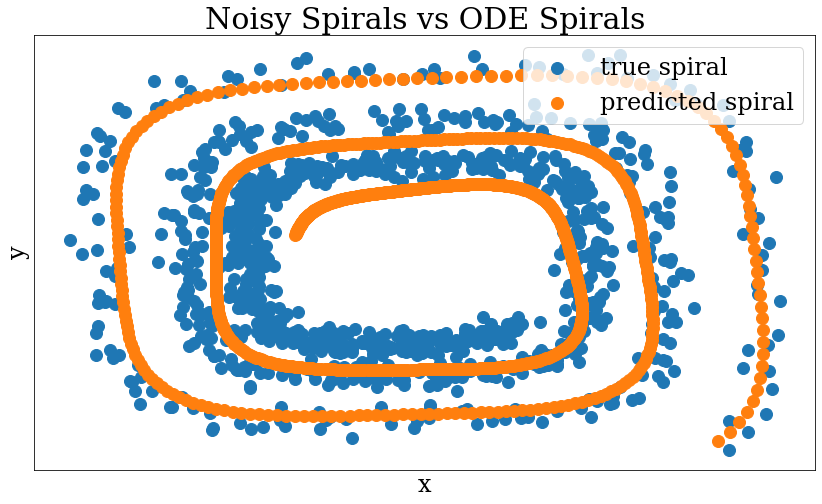

In [119]:
plot_phase_trajectory(
    (noisy_spirals.cpu().numpy(), pred_y.detach().cpu().numpy()), 
    name='Noisy Spirals vs ODE Spirals',
    labels=['true spiral', 'predicted spiral'],
    mode='2D',
    to_save=True,
    clear=False,
)

**Сравнение графиков обучения Neural ODE на обычном и зашумлённом временном ряду**

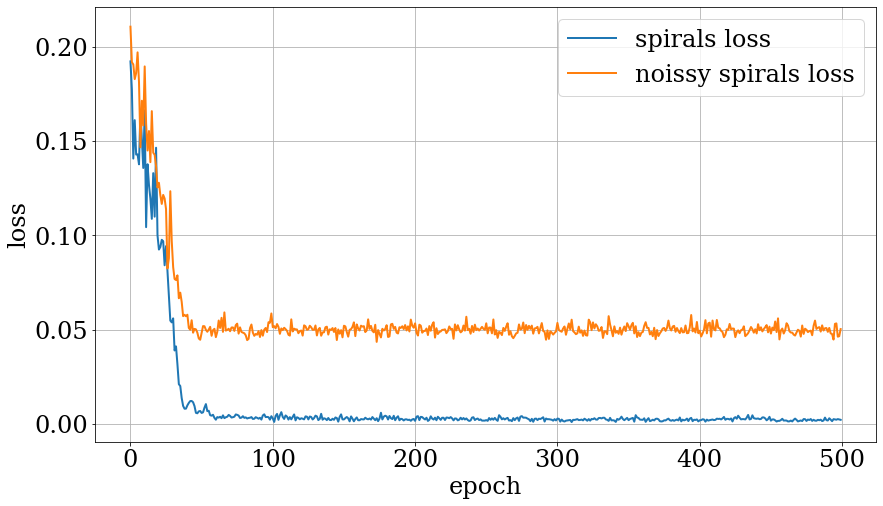

In [123]:
plt.plot(train_loss_arr, label='spirals loss')
plt.plot(noisy_train_loss_arr, label='noissy spirals loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.savefig('train_losses.png')
plt.show()

**Обучение Neural SDE на зашумлённых данных**

In [ ]:
class NoisySpiralFunc(nn.Module):
    def __init__(self, hid_dim: int):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor([[0.04]]), requires_grad=False)
        self.drift = SpiralFunc(hid_dim)
        
        self.noise_type = "diagonal"
        self.sde_type = "stratonovich"
    
    def f(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        return self.drift(ts, inp)
    
    def g(self, ts: torch.Tensor, inp: torch.Tensor) -> torch.Tensor:
        batch_size = inp.shape[0]
        return torch.tile(torch.tensor([[0.0]]), (batch_size, 2))

In [ ]:
N_ITERS = 100

sde_func = NoisySpiralFunc(HID_DIM).to(device)
optimizer = optim.Adam(
    sde_func.parameters(),
    lr=0.005,
    weight_decay=0.01
)
sde_train_loss_arr = []
sde_val_loss_arr = []

for itr in tqdm(range(1, N_ITERS+1)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(
        noisy_spirals,
        ts,
        BATCH_SIZE,
        BATCH_TIME
    )
    pred_y = tsde.sdeint(sde_func, batch_y0, batch_t, rtol=1e-4, atol=1e-6).to(device)
    loss = torch.mean(torch.square(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    sde_train_loss_arr.append(loss.item())

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


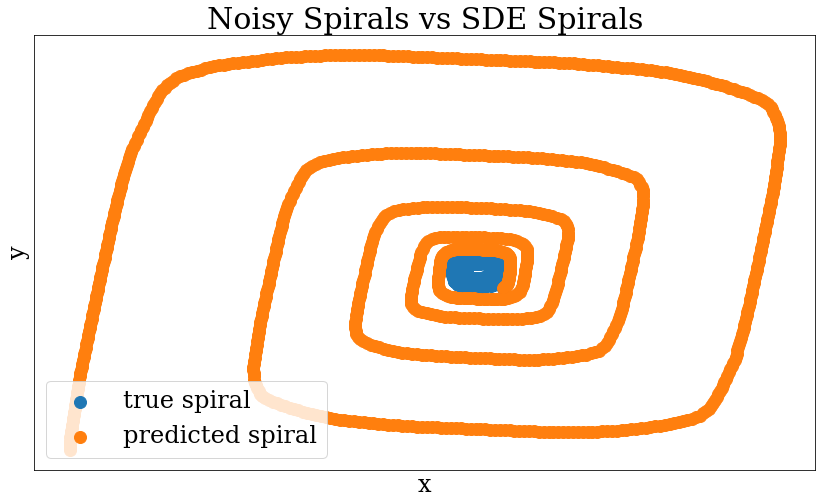

In [ ]:
import sys
sys.setrecursionlimit(1500)

with torch.no_grad():
    pred_y = tsde.sdeint(sde_func, y0.reshape(1, -1), ts).to(device)

plot_phase_trajectory(
    (noisy_spirals.cpu().numpy(), pred_y.detach().cpu().squeeze().numpy()), 
    name='Noisy Spirals vs SDE Spirals',
    labels=['true spiral', 'predicted spiral'],
    mode='2D',
    to_save=True,
    clear=False,
)